In [1]:
# This code provides an architecture which:
# - inputs a function
# - allows a convolutional transformation on that function over its respective mesh
# - returns a singular value belonging to that mesh
# - allows differentiability throughout the entire process, i.e. suitable for a physics-informed loss
# In particular, this architecture is useful because it allows a PINN-type structure over the input function,
#                while concatenating the entire solution at once, which is greatly computationally efficient.
# More specifically, if we wanted the entire solution of the architecture traditionally, we would need to (1) evaluate, (2) then concatenate, which can be costly.
# Traditionally, there is an issue of differentiability when attempting to work with an architecture similar to this. This architecture allows differentiability.

# This architecture was originally created to evaluate a 3x3 Riemannian metric over grid in a physics-informed approach,
#                                           while simultaneously allowing the solution to be concatenated at the same time.

In [136]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import transforms

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [137]:
import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [138]:
# Prepare CIFAR-10 data
phi_np = X_train[0:30000,:,:,:]
phi = torch.from_numpy(phi_np).type(torch.float32).to(device)
phi /= 255.0
phi = torch.reshape(phi, (30000,3,32,32))

In [204]:
num_dx = 6
omega_length =  1.5 * np.pi

X = np.linspace(0,omega_length,num_dx)
Y = np.linspace(0,omega_length,num_dx)
Z = np.linspace(0,omega_length,num_dx)
XX, YY, ZZ = np.meshgrid(X, Y, Z)
XX = torch.unsqueeze(torch.from_numpy(XX).type(torch.float32).to(device),dim=0)
YY = torch.unsqueeze(torch.from_numpy(YY).type(torch.float32).to(device),dim=0)
ZZ = torch.unsqueeze(torch.from_numpy(ZZ).type(torch.float32).to(device),dim=0)

Omega = torch.cat((XX, YY, ZZ),dim=0)
Omega_flat = torch.flatten(Omega, start_dim=1, end_dim=3)

In [205]:
# Proposed architecture

class g_physics_NN(nn.Module):
  def __init__(self):
    super().__init__()

    # Modify width as necessary
    self.conv1 = nn.Conv2d(3, 60, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(60, 110, kernel_size=4, stride=2, padding=1)

    self.time_linear1 = nn.Linear(109, 200, bias=True)
    self.time_linear2 = nn.Linear(200, 8*8*8, bias=True)

    self.conv3 = nn.Conv2d(110 + 16, 250, kernel_size=4, stride=2, padding=1)
    self.conv4 = nn.Conv2d(250, num_dx**3, kernel_size=4, stride=1, padding=1)




  def forward(self, x, Omega, omega_xy, t):
    inputs = x
    spacetime = torch.cat((omega_xy, t), dim=1)

    c = (num_dx - 1) / omega_length
    omega_int =  ( c * omega_xy )

    # Replace exact location among grid with point to be differentiated
    Omega_replace = Omega
    Omega_replace[:,0,omega_int[:,0].int(),omega_int[:,1].int(),omega_int[:,2].int()] = omega_xy[:,0]
    Omega_replace[:,1,omega_int[:,0].int(),omega_int[:,1].int(),omega_int[:,2].int()] = omega_xy[:,1]
    Omega_replace[:,2,omega_int[:,0].int(),omega_int[:,1].int(),omega_int[:,2].int()] = omega_xy[:,2]

    # Take sum to pass into the neural network; sums are differentiable
    Omega_sum = torch.sum(Omega_replace, (4))
    Omega_sum = (Omega_sum.shape[0]/torch.numel(Omega_sum)) * Omega_sum

    # Space and time mesh
    spacetime = torch.cat((Omega_sum.flatten(start_dim=1,end_dim=3), t), dim=1)

    # Pass input data (in this case, CIFAR-10) into the CNN
    x = F.elu(self.conv1(x))
    x = self.conv2(x)

    # Pass spacetime data into neural network
    yt = F.elu(self.time_linear1(spacetime))
    yt = self.time_linear2(yt)
    yt = torch.reshape(yt, (inputs.size(dim=0),8,8,8))
    yt = yt.repeat(1,2,1,1)

    # Concatenate input and spacetime data together and pass into the CNN
    z = F.elu(torch.cat((x, yt), dim=1))
    z = F.elu(self.conv3(z))
    z = self.conv4(z)

    # Ensure symmetry, if desired
    z_grid = (z + torch.transpose(z, 2, 3)) / 2

    # Extract single value from grid
    z_squeeze = z_grid[range(x.size(dim=0)), (num_dx**2)*omega_int[:,0].int() +  num_dx*omega_int[:,1].int() + omega_int[:,2].int(), :, :].squeeze()
    return z_grid, z_squeeze

In [206]:
g_physics = g_physics_NN().to(device).type(torch.float32)

optimizer_physics = optim.Adam([
    {'params': g_physics.parameters()}], lr=2e-4)

As an example, we consider the PDE

$$ \partial_t g(u_1,u_2,u_3,t) = u_1 + u_2 + u_3 + t $$

subject to the initial condition

$$  g(u_1,u_2,u_3,t=0) = u_1 + u_2 + u_3 . $$

In [209]:
# Create loss function from ricci flow

def loss_physics_func(g_physics, phi, Omega_st, uv, tau):


  # Evaluate g
  G_grid, G = g_physics(phi, Omega_st, uv, tau)


  # Compute time derivative of each g component
  g_t = torch.zeros(size=(N,3,3), requires_grad=True).to(device).type(torch.float32)
  for row in range(G.size(dim=1)):
    for col in range(G.size(dim=2)):
      if row <= col:
        g_t[:,row,col] = torch.autograd.grad(G[:,row,col].sum(), tau, create_graph=True)[0][:,0]
        g_t[:,col,row] = torch.autograd.grad(G[:,col,row].sum(), tau, create_graph=True)[0][:,0]

  # Physics loss
  diff_physics = g_t - (tau.squeeze() + uv[:,0] + uv[:,1] + uv[:,2]).view(N,1,1).expand(-1,3,3)
  loss_physics = torch.mean(diff_physics**2)



  # Inital condition loss
  # Initial condition is g(uv,t=0) = uv_1 + uv_2 + uv_3, uv \in R^3

  # Evaluate g
  time_zero = torch.zeros(size=(N,1),requires_grad=True).type(torch.float32).to(device)
  G_grid, G = g_physics(phi, Omega_st, uv, time_zero)
  diff_IC = G - (uv[:,0] + uv[:,1] + uv[:,2]).view(N,1,1).expand(-1,3,3)
  loss_IC = torch.mean(diff_IC**2)


  return loss_physics, loss_IC


In [211]:
num_epochs = 500
N = 500   # batch size
T = 1.0 # final time
time_split_index = N - 30




# Training algorithm to train encoder to metric and decoder from metric to image
for num in range(num_epochs):


  I = np.random.randint(0,int(30000),N)


  omega_i = np.random.randint(0,num_dx,N)
  omega_j = np.random.randint(0,num_dx,N)
  omega_k = np.random.randint(0,num_dx,N)

  u = torch.unsqueeze(Omega[0,omega_i,omega_j,omega_k].flatten(),dim=1)
  v = torch.unsqueeze(Omega[1,omega_i,omega_j,omega_k].flatten(),dim=1)
  w = torch.unsqueeze(Omega[2,omega_i,omega_j,omega_k].flatten(),dim=1)
  uvw = torch.cat((u,v,w),dim=1)
  uvw.requires_grad_()

  Omega_unsq = torch.unsqueeze(Omega,dim=0)
  Omega_stacked = Omega_unsq.repeat(N,1,1,1,1)

  times_unif = np.random.uniform(0.0,T,size=(N,1))
  times_unif = torch.tensor(times_unif, requires_grad=True).type(torch.float32).to(device)


  # Physics-informed loss
  loss_physics, loss_IC = loss_physics_func(g_physics, phi[I,:,:,:], Omega_stacked, uvw, times_unif)


  loss =  loss_physics + loss_IC


  optimizer_physics.zero_grad()
  loss.backward()
  optimizer_physics.step()


  if num % 20 == 0:
    print(loss_physics.detach(), loss_IC.detach())


tensor(2.7012, device='cuda:0') tensor(1.6494, device='cuda:0')
tensor(2.3512, device='cuda:0') tensor(0.4332, device='cuda:0')
tensor(1.8153, device='cuda:0') tensor(0.1671, device='cuda:0')
tensor(1.7326, device='cuda:0') tensor(0.0958, device='cuda:0')
tensor(1.5764, device='cuda:0') tensor(0.0982, device='cuda:0')
tensor(1.3106, device='cuda:0') tensor(0.0482, device='cuda:0')
tensor(1.2552, device='cuda:0') tensor(0.0511, device='cuda:0')
tensor(1.0638, device='cuda:0') tensor(0.0411, device='cuda:0')
tensor(0.9765, device='cuda:0') tensor(0.0313, device='cuda:0')
tensor(0.8681, device='cuda:0') tensor(0.0339, device='cuda:0')
tensor(0.7073, device='cuda:0') tensor(0.0286, device='cuda:0')
tensor(0.5110, device='cuda:0') tensor(0.0533, device='cuda:0')
tensor(0.3036, device='cuda:0') tensor(0.0270, device='cuda:0')
tensor(0.1778, device='cuda:0') tensor(0.0215, device='cuda:0')
tensor(0.0975, device='cuda:0') tensor(0.0212, device='cuda:0')
tensor(0.0614, device='cuda:0') tensor(0

In [212]:
# Test results

tt = 0.5
time_test = tt*torch.ones(size=(500,1),requires_grad=True).type(torch.float32).to(device)
omega_i = np.random.randint(0,num_dx,500)
omega_j = np.random.randint(0,num_dx,500)
omega_k = np.random.randint(0,num_dx,500)

u = torch.unsqueeze(Omega[0,omega_i,omega_j,omega_k].flatten(),dim=1)
v = torch.unsqueeze(Omega[1,omega_i,omega_j,omega_k].flatten(),dim=1)
w = torch.unsqueeze(Omega[2,omega_i,omega_j,omega_k].flatten(),dim=1)
uvw = torch.cat((u,v,w),dim=1)
uvw.requires_grad_()


test_sample_grid, test_sample_uv = g_physics(phi[0:500,:,:,:], Omega_stacked, uvw, time_test)

In [213]:
test_sample = test_sample_grid[0,:,0,0].cpu().detach().numpy().flatten()

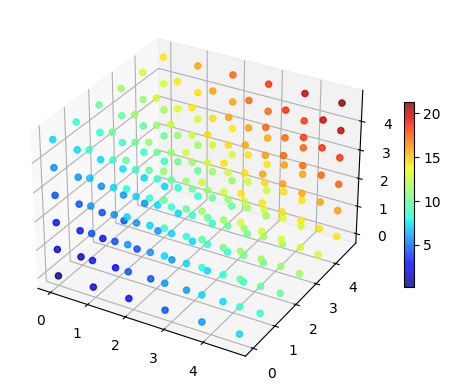

In [214]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# Plot neural network solution
scatter = ax.scatter3D(XX.cpu().detach().numpy(), YY.cpu().detach().numpy(), ZZ.cpu().detach().numpy(), c=test_sample, alpha=0.8, marker='o', cmap='jet')
colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
plt.show()

In [215]:
# True solution

g_true = np.zeros(shape=(num_dx,num_dx,num_dx))
for i in range(num_dx):
  for j in range(num_dx):
    for k in range(num_dx):
      g_true[i,j,k] = ( Omega[0,i,j,k].cpu().detach().numpy()   + \
                        Omega[1,i,j,k].cpu().detach().numpy()   + \
                        Omega[2,i,j,k].cpu().detach().numpy())*(1+tt) \
                        + (tt**2)/2


The true solution to the PDE we chose was

$$ g(u_1,u_2,u_3,t) = \frac{t^2}{2} + (u_1 + u_2 + u_3)(1+t) . $$

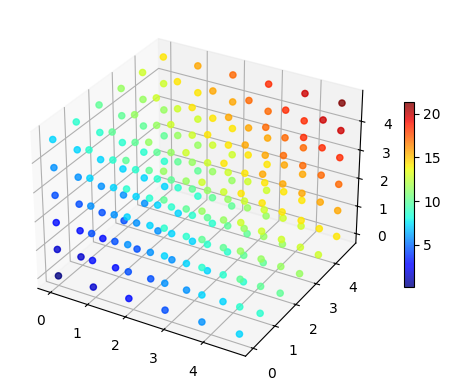

In [216]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# Plot neural network solution
scatter = ax.scatter3D(XX.cpu().detach().numpy(), YY.cpu().detach().numpy(), ZZ.cpu().detach().numpy(), c=g_true, alpha=0.8, marker='o', cmap='jet')
colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
plt.show()